In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import math
import numpy as np

TRAIN_DATA_DIR = '/content/gdrive/MyDrive/data_people/train'
VALIDATION_DATA_DIR = '/content/gdrive/MyDrive/data_people/validation'
TEST_DATA_DIR = '/content/gdrive/MyDrive/data_people/test'

TRAIN_SAMPLES = 300
VALIDATION_SAMPLES = 90
NUM_CLASSES = 3
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [5]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_DIR, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, shuffle=True, seed=12345, class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(VALIDATION_DATA_DIR, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, shuffle=False, class_mode='categorical')

Found 300 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [3]:
def model_maker():
    base_model = VGG16(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    print(len(base_model.layers))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(32, activation='relu')(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)
model_final = model_maker()
model_final.summary()

58889256/58889256 [==============================] - 0s 0us/step
19
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 14731203 (56.20 MB)
Trainable params: 16515 (

In [6]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

history = model_final.fit(
    train_generator, steps_per_epoch=TRAIN_SAMPLES // BATCH_SIZE, # number of updates
    epochs=10,
    validation_data=validation_generator,
    validation_steps=VALIDATION_SAMPLES // BATCH_SIZE)

Epoch 1/10
18/18 [==============================] - 130s 7s/step - loss: 2.9873 - acc: 0.4014 - val_loss: 1.9441 - val_acc: 0.5125
Epoch 2/10
18/18 [==============================] - 37s 2s/step - loss: 1.3381 - acc: 0.5915 - val_loss: 0.9909 - val_acc: 0.7000
Epoch 3/10
18/18 [==============================] - 33s 2s/step - loss: 0.7757 - acc: 0.7042 - val_loss: 0.5220 - val_acc: 0.8125
Epoch 4/10
18/18 [==============================] - 35s 2s/step - loss: 0.6108 - acc: 0.7676 - val_loss: 0.3380 - val_acc: 0.8875
Epoch 5/10
18/18 [==============================] - 37s 2s/step - loss: 0.4995 - acc: 0.8099 - val_loss: 0.2784 - val_acc: 0.8750
Epoch 6/10
18/18 [==============================] - 36s 2s/step - loss: 0.4298 - acc: 0.8345 - val_loss: 0.3266 - val_acc: 0.8750
Epoch 7/10
18/18 [==============================] - 36s 2s/step - loss: 0.3456 - acc: 0.8732 - val_loss: 0.2508 - val_acc: 0.9125
Epoch 8/10
18/18 [==============================] - 33s 2s/step - loss: 0.3258 - acc: 0.8

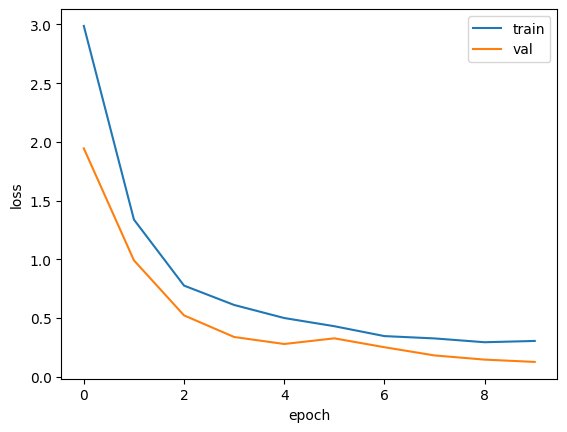

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

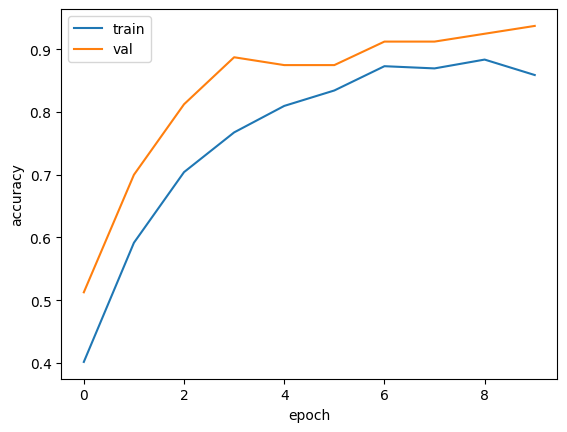

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [9]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = val_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')

Found 60 images belonging to 3 classes.


In [10]:
model_final.evaluate(test_generator, steps=60 // BATCH_SIZE)

3/3 [==============================] - 14s 6s/step - loss: 0.3724 - acc: 0.9375


[0.3723607361316681, 0.9375]

1/1 [==============================] - 1s 1s/step


Predicted probabilities: [9.9995708e-01 1.9043988e-05 2.3791141e-05]
Predicted class index: 0
Predicted class label: harin
All class labels in the dataset: {'harin': 0, 'pildo': 1, 'yera': 2}


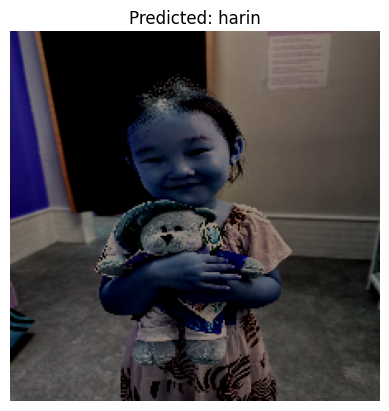

In [11]:
# Load and preprocess the test image
img_path = '/content/gdrive/MyDrive/data_people/test1.jpg'  # Correct path
img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))  # Target size already set
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape
img_array = np.expand_dims(img_array, axis=0)
# Preprocess the image using the same preprocessing function as the training data
img_array = preprocess_input(img_array)

# Make a prediction using the trained model
prediction = model_final.predict(img_array)

# Decode the prediction into class labels
class_labels = train_generator.class_indices  # Get class indices from the generator
predicted_class_index = np.argmax(prediction)
predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

# Print the prediction results
print(f"Predicted probabilities: {prediction[0]}")
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class label: {predicted_class_label}")
print(f"All class labels in the dataset: {class_labels}")

# Display the image
plt.imshow(img_array[0] / 255.)
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()

In [12]:
import os
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    TEST_DATA_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,  # Process one image at a time
    shuffle=False,  # Important to keep the order for matching filenames
    class_mode='categorical'
)

# Get the filenames from the generator
filenames = test_generator.filenames

# Loop through the test images
for i in range(len(filenames)):
    # Load and preprocess the image
    img_path = os.path.join(TEST_DATA_DIR, filenames[i])
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make a prediction
    prediction = model_final.predict(img_array)

    # Decode the prediction
    class_labels = train_generator.class_indices
    predicted_class_index = np.argmax(prediction)
    predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

    # Print and display the results
    print(f"\nImage: {filenames[i]}")
    print(f"Predicted probabilities: {prediction[0]}")
    print(f"Predicted class label: {predicted_class_label}")

    plt.imshow(img_array[0] / 255.)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.